<a href="https://colab.research.google.com/github/NguyenYen153/My-code/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LSTM**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pyvi

     |████████████████████████████████| 8.5MB 1.5MB/s 
     |████████████████████████████████| 747kB 54.4MB/s 


In [0]:
import os
import pickle
import random
from collections import Counter

import numpy as np
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
import gensim
import torch
from torchtext import data
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

from pyvi import ViTokenizer
import re, os, string
import pandas as pd
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import unicodedata as ud
import random
import csv
import time
from tqdm import tqdm
from gensim import utils
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models import Doc2Vec

In [0]:
from sklearn.svm import LinearSVC
from gensim import corpora, matutils
from sklearn.metrics import roc_curve, f1_score, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import nltk
from collections import defaultdict
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
data_path = '/content/drive/My Drive/data/VNFN/'
file_stopwords = 'Dictionaries/Stopwords_vi.txt'
d2v_model_path = 'em_model/doc2vec_model.vec'
w2v_path_pre_trained = 'em_model/baomoi.vn.model.bin'
w2v_model_path = '/content/drive/My Drive/LuanVan/model/word2vec_skipgram.model'

In [0]:
csv_226 = 'pre_data/preproc_vn_news_226_tlfr.csv' 
csv_223 = 'pre_data/preproc_vn_news_223_tdlfr.csv' 
csv_376 = 'pre_data/preproc_vn_news_376.csv'

In [0]:
'''from torch.utils.data import Dataset, DataLoader, random_split
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # store the inputs and outputs
        self.path = path
    def get_data(self):
        vocab = defaultdict(float)
        with open(self.path, "r", encoding ='utf-8') as f:
              reader = pd.read_csv(f)
              texts = reader['text'].values + reader['title'] 
              labels = reader['label'].values
              tex = []
              for text in texts:
                  tex.append(''.join(str(text)))
              words = set(str(tex).split())#(i.split() for i in tex)
              for word in words:
                  vocab[word] += 1
        return texts, labels, vocab
      # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
        dataset = CSVDataset(os.path.join(data_path, csv_376))
texts, labels, vocab = dataset.get_data()
        '''

'from torch.utils.data import Dataset, DataLoader, random_split\nclass CSVDataset(Dataset):\n    # load the dataset\n    def __init__(self, path):\n        # store the inputs and outputs\n        self.path = path\n    def get_data(self):\n        vocab = defaultdict(float)\n        with open(self.path, "r", encoding =\'utf-8\') as f:\n              reader = pd.read_csv(f)\n              texts = reader[\'text\'].values + reader[\'title\'] \n              labels = reader[\'label\'].values\n              tex = []\n              for text in texts:\n                  tex.append(\'\'.join(str(text)))\n              words = set(str(tex).split())#(i.split() for i in tex)\n              for word in words:\n                  vocab[word] += 1\n        return texts, labels, vocab\n      # number of rows in the dataset\n    def __len__(self):\n        return len(self.X)\n \n    # get a row at an index\n    def __getitem__(self, idx):\n        return [self.X[idx], self.y[idx]]\n        dataset = CSV

In [0]:
def DataReader(data_path, csv_path):
    datas = []
    with open(os.path.join(data_path, csv_path), 'r') as csv_file:
      reader = csv.DictReader(csv_file)
      datas = list(reader)
    return datas
def get_data(datas):
    texts = []
    labels = []
    for train in datas:
        texts.append(' '.join(train['text'].split()+train['title'].split()) +'.'+train['domain'])
        labels.append(train['label'])
    return texts, labels

In [0]:
%%time
w2v = KeyedVectors.load_word2vec_format(os.path.join(data_path, w2v_path_pre_trained), binary = True)
vocab = w2v.wv.vocab
wv = w2v.wv

def get_word2vec_data(X):
    word2vec_data = []
    for x in X:
        sentence = []
        for word in str(x).split(" "):
            if word in vocab:
                sentence.append(wv[word])

        word2vec_data.append(sentence)

    return word2vec_data

#X_train_w2v = get_word2vec_data(X_train)
#X_test_w2v = get_word2vec_data(X_test)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 5.04 s, sys: 689 ms, total: 5.73 s
Wall time: 8.37 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
datas = DataReader(data_path, csv_376)
texts, labels = get_data(datas)
#exts

In [0]:
f_token = 'tokenized_texts.pkl'
tokenized_texts = []
for train in texts:
    for i in train.split():
              tokenized_texts.append(i)
print(len(set(tokenized_texts)))
with open(os.path.join(data_path,f_token), 'wb') as f:
  pickle.dump(tokenized_texts, f)

12063


In [0]:
#convert label to number
y_num = []
for i in labels:
    if i == '0':
      y_num.append(0)
    elif i== '1':
      y_num.append(1)
labels = y_num

In [0]:
X_train, X_test, y_train, y_test = train_test_split(texts,labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.6)
#len(y_train)

In [0]:
with open(os.path.join(data_path, file_stopwords)) as f:
    list_stopwords = f.read()

**Word2vec**

In [0]:
'''%%time
w2v = KeyedVectors.load_word2vec_format(os.path.join(data_path, w2v_path_pre_trained))
vocab = w2v.wv.vocab
wv = w2v.wv

def get_word2vec_data(X):
    word2vec_data = []
    for x in X:
        sentence = []
        for word in x.split(" "):
            if word in vocab:
                sentence.append(wv[word])

        word2vec_data.append(sentence)

    return word2vec_data

X_train_w2v = get_word2vec_data(X_train)
X_test_w2v = get_word2vec_data(X_test)
'''

'%%time\nw2v = KeyedVectors.load_word2vec_format(os.path.join(data_path, w2v_path_pre_trained))\nvocab = w2v.wv.vocab\nwv = w2v.wv\n\ndef get_word2vec_data(X):\n    word2vec_data = []\n    for x in X:\n        sentence = []\n        for word in x.split(" "):\n            if word in vocab:\n                sentence.append(wv[word])\n\n        word2vec_data.append(sentence)\n\n    return word2vec_data\n\nX_train_w2v = get_word2vec_data(X_train)\nX_test_w2v = get_word2vec_data(X_test)\n'

In [0]:
def make_embedding(texts, embedding_path, max_features):
    embedding_path = os.path.abspath(embedding_path)

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    if embedding_path.endswith('.vec'):
        embedding_index = dict(get_coefs(*o.strip().split(" "))
                               for o in open(embedding_path))
        mean_embedding = np.mean(np.array(list(embedding_index.values())))
    elif embedding_path.endswith('bin'):
        embedding_index = KeyedVectors.load_word2vec_format(
            embedding_path, binary=True)
        mean_embedding = np.mean(embedding_index.vectors, axis=0)
    embed_size = mean_embedding.shape[0]
    word_index = sorted(list({word.lower() for sentence in texts for word in sentence}))
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    i = 1
    word_map = defaultdict(lambda: nb_words)
    for word in word_index:
        if i >= max_features:
            continue
        if word in embedding_index:
            embedding_matrix[i] = embedding_index[word]
        else:
            embedding_matrix[i] = mean_embedding
        word_map[word] = i
        i += 1
    
    embedding_matrix[-1] = mean_embedding
    return embed_size, word_map, embedding_matrix

In [0]:
embed_size, word_map, embedding_matrix = make_embedding(tokenized_texts, os.path.join(data_path, w2v_path_pre_trained), 15000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Doc2vec**

In [0]:
def get_corpus(documents):
    corpus = []
    
    for i in tqdm(range(len(documents))):
        doc = documents[i]
        
        words = doc.split(' ')
        tagged_document = TaggedDocument(words, [i])
        
        corpus.append(tagged_document)
        
    return corpus
train_corpus = get_corpus(X_train)
test_corpus = get_corpus(X_test)

100%|██████████| 45/45 [00:00<00:00, 11524.22it/s]


In [0]:
 for i in tqdm(range(len(X_train))):
        doc = X_train[i]
        print(doc)

100%|██████████| 263/263 [00:00<00:00, 9457.00it/s]

ăn_đậu thi đâu đậu hay ăn bắp bài làm chắc bắp món kỳ thi bạn dịp thưởng_thức sĩ tử hiện trong giai_đoạn vật_lộn kỳ thi cực_kỳ_quan_trọng đời mình chính kỳ thi tốt_nghiệp thpt sống tốt mùa thi sĩ tử chúng_ta bỏ_qua thực_phẩm nhé nó giúp sĩ tử nâng cao sức_khỏe mình còn giúp tăng_cường hệ_thống miễn_dịch giúp thoải_mái tăng khả_năng tập_trung giúp sĩ tử đạt kết_quả cao trong kỳ thi sắp tới món đậu loại đậu trong thực_phẩm tốt nhất giúp tăng_cường tập_trung chúng giúp điều_chỉnh năng_lượng ổn_định mức đường_huyết cơ_thể bên cạnh ông_bà ta thường căn_dặn con_cháu thi ăn đậu thi đâu đậu ăn_chè đậu thi đậu nha hột vịt lộn hôm_nay bài_làm bạn suôn_sẻ như_ý_muốn mình hãy nghe lời dân_gian ăn hột vịt lộn lộn ngược tình_thế nhé hột vịt lộn còn khả_năng trị đau_đầu chứa hàm_lượng dinh_dưỡng khá cao phù_hợp bạn bồi_bổ bản_thân sức chiến kỳ thi cam_go tuy_nhiên đừng ăn buổi tối hột vịt hàn tốt cơ_thể sô cô la đen sô cô la đen thực_phẩm đánh_giá mang lợi_ích não bộ chất cafein tìm thấy trong sô cô 

In [0]:
model_d2v = Doc2Vec(vector_size=300, min_count=2, epochs=40)
model_d2v.build_vocab(train_corpus)
%time 
model_d2v.train(train_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
model_d2v.save(os.path.join(data_path, d2v_model_path ))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_doc2vec_data(model, X_corpus):
    X_vector = []
    for x in X_corpus:
          vector = model.infer_vector(x.words)
          X_vector.append(vector)
    return X_vector
#GET vector of document
X_train_d2v = get_doc2vec_data(model_d2v, train_corpus)
X_test_d2v = get_doc2vec_data(model_d2v, test_corpus)

In [0]:
with open(os.path.join(data_path,f_token), 'rb') as f:
    tokenized_texts = pickle.load(f)

[('n', 115513),
 ('h', 87876),
 ('_', 84527),
 ('t', 65741),
 ('g', 52753),
 ('i', 51139),
 ('c', 46252),
 ('u', 27150),
 ('a', 23808),
 ('m', 21003)]

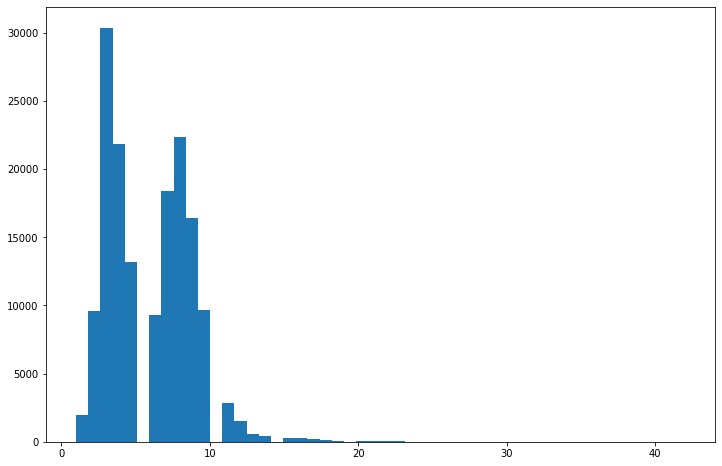

In [0]:
lens = np.array(list(map(len, tokenized_texts)))
plt.figure(figsize=[12, 8])
_ = plt.hist(lens, bins=50) 

word_counter = Counter()
for t in tokenized_texts:
    word_counter.update(t)
word_counter.most_common(10)

In [0]:
# Keras
from keras.utils import to_categorical, plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import Dense,Input, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, BatchNormalization,Bidirectional, TimeDistributed

from keras.models import Model, Sequential, model_from_json, load_model

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, Callback, CSVLogger
from keras import backend as K

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters='\t\n',lower=True)
tokenizer.fit_on_texts(list(texts))
sequences = tokenizer.texts_to_sequences(texts)
#len vocab = 12063
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 12063


In [0]:
vocab_size = len(word_index)
maxlen = 300
max_sent = 15
em_dim = 300
batch_size = 32
embedding_type = 'em_model'
seed = 21
np.random.seed(seed)

In [0]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))
y_val = to_categorical(np.asarray(y_val))

**LSTM**

In [0]:
# Dumping tokenizer using joblib which is faster than pickle
joblib.dump(tokenizer, os.path.join(data_path,
                                    '{}/tokenizer.pickle'.format(embedding_type)))

# Generating sequences & padding for efficient training of our neural network
# Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = sequence.pad_sequences(train_sequences, maxlen=maxlen)

val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded_sequences = sequence.pad_sequences(val_sequences, maxlen=maxlen)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=maxlen)


# Initializing & running keras model

print('\n\n****************** Keras model training started. *******************\n\n')

# Setting checkpoint & early stopping
checkpoint_path = os.path.join(os.path.join(data_path, embedding_type),
                               'model_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# prefroc_callback = PrefrocCallback(training_data=(train_padded_sequences, y_train), validation_data=(val_padded_sequences, y_val))

tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=2000, write_graph=True, write_images=False)

callbacks_list = [checkpoint, tensorboard]

# Running the pipeline
# Fixing the seed again
np.random.seed(seed)

print('\n\nBuild model ...')
model = Sequential()
model.add(Embedding(vocab_size, em_dim, input_length=maxlen))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

print('Training starts...')
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=50,
          validation_data=(val_padded_sequences, y_val),
          verbose=2, callbacks=callbacks_list)



****************** Keras model training started. *******************




Build model ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          3618900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 4,340,702
Trainable params: 4,340,702
Non-trainable params: 0
_________________________________________________________________
None
Training starts...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 263 samples, validate on 68 samples
Epoch 1/50
 - 10s - loss: 0.6850 - accuracy: 0.6008 - val_loss: 0.6404 - val_accuracy: 0.6176

Epoch 00001: val_accuracy improved from -inf to 0.61765, saving model to /content/drive/My Drive/data/VNFN/em_model/model_best_weights.01-0.6176.hdf5
Epoch 2/50
 - 6s - loss: 0.5554 - accuracy: 0.7795 - val_loss: 0.6227 - val_accuracy: 0.7059

Epoch 00002: val_accuracy improved from 0.61765 to 0.70588, saving model to /content/drive/My Drive/data/VNFN/em_model/model_best_weights.02-0.7059.hdf5
Epoch 3/50
 - 6s - loss: 0.3974 - accuracy: 0.9582 - val_loss: 0.8547 - val_accuracy: 0.6912

Epoch 00003: val_accuracy did not improve from 0.70588
Epoch 4/50
 - 6s - loss: 0.1369 - accuracy: 0.9772 - val_loss: 0.5077 - val_accuracy: 0.7794

Epoch 00004: val_accuracy improved from 0.70588 to 0.77941, saving model to /content/drive/My Drive/data/VNFN/em_model/model_best_weights.04-0.7794.hdf5
Epoch 5/50
 - 6s - loss: 0.0321 - accuracy: 1.0000 - val_loss: 0.60

In [0]:
scores = model.evaluate(test_padded_sequences, y_test,
                        batch_size=batch_size)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

45/45 [==============================] - 0s 2ms/step
Loss: 0.5143854114744398
Accuracy: 0.800000011920929


In [0]:
model_LSTM = 'model_lstm.h5'
model_name = os.path.join(data_path,model_LSTM)
model.save(model_name)

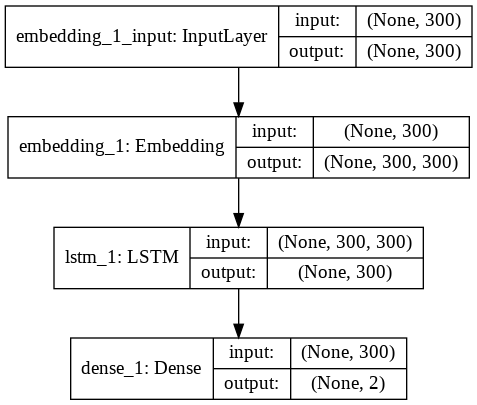

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

from PIL import Image
display(Image.open('cnn_model.png'))

##**Bi-LSTM**

In [0]:
max_features = 15000

# Initializing & running keras model

print('\n\n****************** Keras model training started. *******************\n\n')

# Setting checkpoint & early stopping
checkpoint_path = os.path.join(os.path.join(data_path, embedding_type),
                               'model_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# prefroc_callback = PrefrocCallback(training_data=(train_padded_sequences, y_train), validation_data=(val_padded_sequences, y_val))

tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=2000, write_graph=True, write_images=False)

callbacks_list = [checkpoint, tensorboard]

# Running the pipeline
# Fixing the seed again
np.random.seed(seed)

print('\n\nBuild model ...')
model = Sequential()
model.add(Embedding(vocab_size +1, 300, input_length=maxlen))
model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

print('Train...')
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=50,
          validation_data=(val_padded_sequences, y_val),
          verbose=2, callbacks=callbacks_list)



****************** Keras model training started. *******************




Build model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          3619200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1202      
Total params: 5,062,802
Trainable params: 5,062,802
Non-trainable params: 0
_________________________________________________________________
None
Train...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 263 samples, validate on 68 samples
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.527679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 14s - loss: 0.6697 - accuracy: 0.6293 - val_loss: 0.6664 - val_accuracy: 0.6176

Epoch 00001: val_accuracy improved from -inf to 0.61765, saving model to /content/drive/My Drive/data/VNFN/em_model/model_best_weights.01-0.6176.hdf5
Epoch 2/50
 - 10s - loss: 0.6144 - accuracy: 0.6749 - val_loss: 0.6442 - val_accuracy: 0.6176

Epoch 00002: val_accuracy did not improve from 0.61765
Epoch 3/50
 - 10s - loss: 0.4249 - accuracy: 0.8137 - val_loss: 0.4626 - val_accuracy: 0.7941

Epoch 00003: val_accuracy improved from 0.61765 to 0.79412, saving model to /content/drive/My Drive/data/VNFN/em_model/model_best_weights.03-0.7941.hdf5
Epoch 4/50
 - 10s - loss: 0.1198 - accuracy: 0.9696 - val_loss: 1.0484 - val_accuracy: 0.7353

Epoch 00004: val_accuracy did not improve from 0.79412
Epoch 5/50
 - 10s - loss: 0.0491 - accuracy: 0.9886 - val_loss: 0.5080 - val_accuracy: 0.7574

Epoch 00005: val_accuracy did not improve from 0.79412
Epoch 6/50
 - 10s - loss: 0.0338 - accuracy: 0.9962 - val_loss: 0.87

In [0]:
scores = model.evaluate(test_padded_sequences, y_test,
                        batch_size=batch_size)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

45/45 [==============================] - 0s 4ms/step
Loss: 1.388084716267056
Accuracy: 0.7333333492279053


In [0]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
y_pred=model.predict_classes(X_test)
print('Classification report:\n',classification_report(y_test,y_pred))
#print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
#print(y_pred)
'''
model = load_model('Models/Model_cnn_FR_2.h5')
model.name='Model_cnn_FR_2.h5'
'''

from sklearn.metrics import precision_recall_fscore_support, classification_report
y_pred=model.predict_classes(X_test)
print('Classification Report: '+classification_report(y_test, y_pred))


import pickle
with open('Predictions/pickle_Pred_CNN_1_FR.pickle','wb') as f:
    pickle.dump((y_test,y_pred),f)

In [0]:
model_LSTM = 'model_lstm.h5'
model_name = os.path.join(data_path,model_LSTM)
model.save(model_name)

##**CNN**

In [0]:

#Max no of Vocab
vocabulary_size = 400000

time_step=300
embedding_size=100
#Tokenizing texts
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences_train= tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences_train, maxlen=time_step,padding='post')

print(len(tokenizer.word_index))


vocab_size=len(tokenizer.word_index)+1

#Reading Glove
f = open('glove.6B.100d.txt',encoding='utf-8')
embeddings={}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape[0],embedding_matrix.shape[1])


sequences_test= tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences_test, maxlen=time_step,padding='post')

# Embedding
#maxlen = 100
#embedding_size = 32

# Convolution
filter_length = 3
nb_filter = 128



model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=time_step,
                    weights=[embedding_matrix],trainable=False))
#model.add(Dropout(0.4))

#model.add(LSTM(128))

model.add(Conv1D(filters=nb_filter,
                        kernel_size=filter_length,
                        activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

#model.add(Dense(units=128,activation='relu'))
#model.add(Dropout(rate=0.8))



model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=64,epochs=10)


print("Saving Model...")
model_name = 'Models/Model_cnn_FR_2.h5'########################################3
model.save(model_name)#################################################

score=model.evaluate(X_test,y_test,verbose=1)
print('acc: '+str(score[1]))

from sklearn.metrics import precision_recall_fscore_support,classification_report
y_pred=model.predict_classes(X_test)
print('Classification report:\n',classification_report(y_test,y_pred))
#print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
#print(y_pred)
'''
model = load_model('Models/Model_cnn_FR_2.h5')
model.name='Model_cnn_FR_2.h5'
'''

from sklearn.metrics import precision_recall_fscore_support, classification_report
y_pred=model.predict_classes(X_test)
print('Classification Report: '+classification_report(y_test, y_pred))


import pickle
with open('Predictions/pickle_Pred_CNN_1_FR.pickle','wb') as f:
    pickle.dump((y_test,y_pred),f)